# 🧠 Pemodelan Klasifikasi — Deep Dive Naive Bayes

### Jembatan Konseptual

Selamat datang di bagian **1.a**, bagian pertama dari seri pemodelan klasifikasi kita. Setelah pada tahap-tahap sebelumnya kita telah melakukan **Data Understanding** dan **Pra-Pemrosesan**, kita kini siap untuk memulai pemodelan.

Kita akan memulai dengan model yang elegan dan berbasis probabilitas: **Naive Bayes**.

### Filosofi Naive Bayes: "Probabilitas Bersyarat"

Naive Bayes bekerja berdasarkan **Teorema Bayes**, sebuah prinsip fundamental dalam teori probabilitas. 

> **Analogi Sederhana:** Bayangkan seorang dokter yang mendiagnosis penyakit. Dokter tersebut tidak hanya melihat gejala yang ada pada pasien (`P(Gejala|Penyakit)`), tetapi juga mempertimbangkan seberapa umum penyakit itu di populasi secara umum (`P(Penyakit)`). Dengan menggabungkan dua informasi ini, dokter dapat membuat diagnosis yang lebih akurat (`P(Penyakit|Gejala)`).

Model ini disebut **'naive' (naif)** karena ia membuat asumsi yang menyederhanakan masalah: yaitu bahwa semua fitur (misalnya, `sepal_length` dan `petal_width`) bersifat **independen** satu sama lain. Meskipun asumsi ini jarang sekali benar di dunia nyata, Naive Bayes seringkali bekerja dengan sangat baik dan cepat.

Di notebook ini, kita akan membangun, mengevaluasi, dan "membedah" isi dari model Gaussian Naive Bayes untuk benar-benar memahami cara kerjanya.

### Langkah 1: Setup Mandiri & Persiapan Data Lengkap

Sebagai notebook mandiri, sel pertama ini akan menangani semua yang kita butuhkan: mengimpor pustaka, memuat data mentah, dan menerapkan seluruh alur pra-pemrosesan yang telah kita putuskan sebelumnya (standarisasi dan penghapusan outlier dengan LOF), hingga membagi data menjadi set pelatihan dan pengujian.

In [1]:
# =======================================================
# SETUP MANDIRI UNTUK PEMODELAN NAIVE BAYES
# =======================================================

# 1. Import Pustaka
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print("Pustaka yang dibutuhkan telah diimpor.")

# 2. Memuat dan Membuat DataFrame Awal
iris = load_iris()
df_full = pd.DataFrame(data=iris.data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
df_full['species'] = [iris.target_names[i] for i in iris.target]
print("Dataset Iris mentah berhasil dibuat.")

# 3. Pra-Pemrosesan: Standarisasi & Penghapusan Outlier dengan LOF
print("\nMemulai pra-pemrosesan...")
# Penskalaan (diperlukan untuk LOF dan bisa membantu asumsi Gaussian pada Naive Bayes)
features_to_scale = df_full[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_to_scale)

# Deteksi Outlier dengan LOF
lof = LocalOutlierFactor(n_neighbors=20)
outlier_labels = lof.fit_predict(features_scaled)
df_full['outlier_lof'] = outlier_labels

# Menghapus Outlier
df_processed = df_full[df_full['outlier_lof'] == 1].copy()
df_processed = df_processed.drop(columns=['outlier_lof'])
print(f"Penghapusan outlier selesai. Sisa data: {df_processed.shape[0]} baris.")

# 4. Pra-Pemrosesan: Label Encoding pada Target
encoder = LabelEncoder()
df_processed['species_encoded'] = encoder.fit_transform(df_processed['species'])
print("Label encoding untuk variabel target selesai.")

# 5. Memisahkan Fitur (X) dan Target (y)
# Kita akan menggunakan data yang sudah diskalakan
X_unscaled = df_processed[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
X = scaler.fit_transform(X_unscaled) # Skalakan ulang pada data yang sudah bersih
y = df_processed['species_encoded']

# 6. Pembagian Data (Train-Test Split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("\nPembagian data menjadi set latih dan uji selesai.")
print(f"Ukuran X_train: {X_train.shape}")
print(f"Ukuran X_test: {X_test.shape}")

Pustaka yang dibutuhkan telah diimpor.
Dataset Iris mentah berhasil dibuat.

Memulai pra-pemrosesan...
Penghapusan outlier selesai. Sisa data: 144 baris.
Label encoding untuk variabel target selesai.

Pembagian data menjadi set latih dan uji selesai.
Ukuran X_train: (100, 4)
Ukuran X_test: (44, 4)


### Langkah 2: Membangun & Mengevaluasi Model Naive Bayes

Kita akan menggunakan varian `GaussianNB` dari Scikit-learn, yang cocok untuk fitur-fitur kontinu (seperti ukuran sepal dan petal) karena ia mengasumsikan bahwa fitur untuk setiap kelas mengikuti distribusi normal (Gaussian).

--- Laporan Klasifikasi Model Gaussian Naive Bayes ---
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.93      0.87      0.90        15
   virginica       0.87      0.93      0.90        14

    accuracy                           0.93        44
   macro avg       0.93      0.93      0.93        44
weighted avg       0.93      0.93      0.93        44



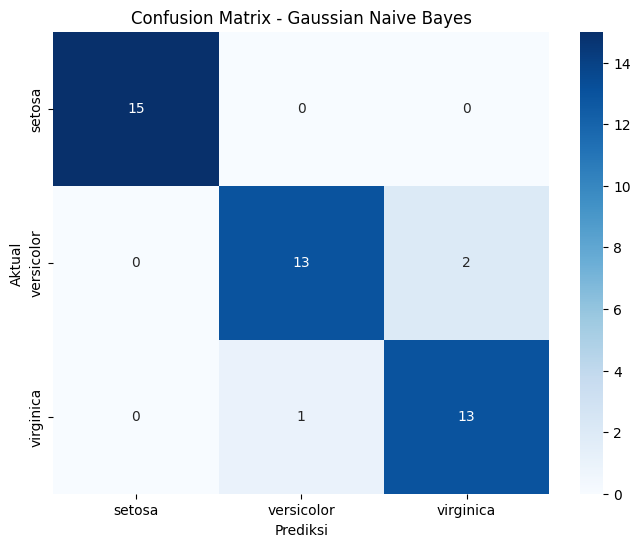

In [2]:
# Inisialisasi dan latih model Gaussian Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Lakukan prediksi pada data uji
y_pred = nb_model.predict(X_test)

# Evaluasi model
print("--- Laporan Klasifikasi Model Gaussian Naive Bayes ---")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# Visualisasi Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix - Gaussian Naive Bayes')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

**Analisis Awal:** Model Naive Bayes menunjukkan performa yang sangat baik, dengan akurasi tinggi dan hanya sedikit kesalahan klasifikasi antara `versicolor` dan `virginica`, sesuai dengan yang kita harapkan dari analisis data awal.

### Langkah 3: "Deep Dive" — Membedah Isi Model Naive Bayes

Keindahan Naive Bayes adalah kita bisa dengan mudah melihat apa yang telah ia "pelajari" dari data. Mari kita lihat ke dalam model.

#### 3.1 Menganalisis Probabilitas Prior (`class_prior_`)
Ini adalah probabilitas awal dari setiap kelas, yang dihitung dari proporsi masing-masing kelas di data latihan. Ini adalah `P(Penyakit)` dalam analogi dokter kita.

In [3]:
priors = nb_model.class_prior_
prior_df = pd.DataFrame(priors, index=encoder.classes_, columns=['Probabilitas Prior'])

print("--- Probabilitas Prior yang Dipelajari Model ---")
display(prior_df.round(4))

--- Probabilitas Prior yang Dipelajari Model ---


,Probabilitas Prior
setosa,0.32
versicolor,0.35
virginica,0.33


Karena data kita seimbang, probabilitas prior untuk setiap kelas hampir sama (sekitar 33%).

#### 3.2 Menganalisis Parameter Distribusi (`theta_` dan `var_`)
`GaussianNB` mempelajari rata-rata (`theta_`) dan varians (`var_`) untuk setiap fitur di setiap kelas. Parameter-parameter inilah yang mendefinisikan kurva lonceng (distribusi normal) untuk setiap kombinasi fitur-kelas.

In [4]:
means = nb_model.theta_
variances = nb_model.var_
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

params_df = pd.DataFrame(means, columns=[f'{name}_mean' for name in feature_names])
params_df = pd.concat([
    params_df, 
    pd.DataFrame(variances, columns=[f'{name}_var' for name in feature_names])
], axis=1)
params_df.index = encoder.classes_

print("--- Rata-rata (theta) dan Varians (var) yang Dipelajari Model ---")
display(params_df.round(4))

--- Rata-rata (theta) dan Varians (var) yang Dipelajari Model ---


,sepal_length_mean,sepal_width_mean,petal_length_mean,petal_width_mean,sepal_length_var,sepal_width_var,petal_length_var,petal_width_var
setosa,-1.0340,0.8614,-1.3322,-1.2826,0.1754,0.5537,0.0065,0.0195
versicolor,0.1578,-0.7917,0.2966,0.1473,0.3913,0.5406,0.0663,0.0652
virginica,0.8470,-0.2534,1.0065,1.0919,0.4820,0.4908,0.0843,0.1401


#### 3.3 Visualisasi Distribusi Gaussian yang Dipelajari Model
Ini adalah bagian yang paling menarik. Mari kita visualisasikan kurva lonceng yang telah dipelajari model menggunakan parameter rata-rata dan varians di atas, dan kita bandingkan dengan distribusi data yang sebenarnya.

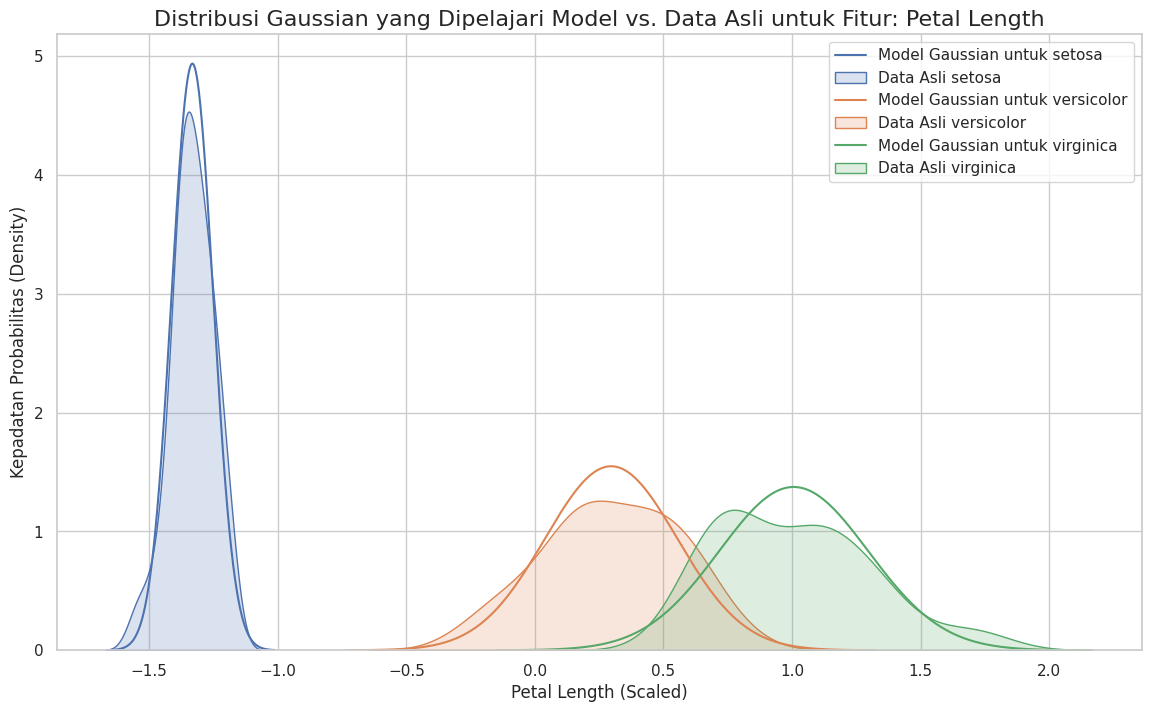

In [5]:
# Pilih fitur untuk divisualisasikan, misal 'petal_length'
feature_index = 2 # Indeks untuk petal_length
feature_name = feature_names[feature_index]

plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

for i, class_name in enumerate(encoder.classes_):
    # Dapatkan parameter yang dipelajari model
    mean = nb_model.theta_[i, feature_index]
    std_dev = np.sqrt(nb_model.var_[i, feature_index])
    
    # Buat rentang nilai untuk plot
    x_axis = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)
    # Hitung PDF (Probability Density Function)
    pdf = stats.norm.pdf(x_axis, loc=mean, scale=std_dev)
    
    # Plot kurva Gaussian yang dipelajari model
    plt.plot(x_axis, pdf, label=f'Model Gaussian untuk {class_name}')
    
    # Plot distribusi data asli untuk perbandingan
    sns.kdeplot(X_train[y_train == i, feature_index], label=f'Data Asli {class_name}', fill=True, alpha=0.2)

plt.title(f'Distribusi Gaussian yang Dipelajari Model vs. Data Asli untuk Fitur: {feature_name.replace("_", " ").title()}', fontsize=16)
plt.xlabel(f'{feature_name.replace("_", " ").title()} (Scaled)')
plt.ylabel('Kepadatan Probabilitas (Density)')
plt.legend()
plt.show()

**Analisis Visualisasi:**
Grafik ini secara visual menunjukkan bagaimana Naive Bayes bekerja. Garis tebal adalah kurva probabilitas yang "diyakini" oleh model, sedangkan area yang diarsir adalah distribusi data yang sebenarnya.
* Kurva untuk **setosa** sangat terpisah dari yang lain, menjelaskan mengapa model tidak pernah salah mengklasifikasikannya.
* Kurva untuk **versicolor** dan **virginica** memiliki tumpang tindih yang signifikan. Di area tumpang tindih inilah model membuat keputusan berdasarkan probabilitas prior dan bukti dari fitur-fitur lain. Ini juga menjelaskan mengapa kesalahan klasifikasi terjadi di antara kedua kelas ini.
Secara umum, asumsi distribusi normal dari model (garis tebal) cukup cocok dengan distribusi data asli (area arsir).

### Penutup dan Jembatan Konseptual

Dalam notebook ini, kita tidak hanya membangun model **Naive Bayes** tetapi juga melakukan penyelidikan mendalam ke dalam cara kerjanya. Kita melihat bagaimana probabilitas prior dan parameter distribusi Gaussian digunakan untuk membuat keputusan klasifikasi. Naive Bayes terbukti menjadi model yang sangat cepat dan efektif untuk dataset ini.

#### Jembatan ke Seri Selanjutnya

Setelah memahami model probabilistik ini, pada **[bagian selanjutnya (1.b)](./1.b_Klasifikasi_KNN.ipynb)**, kita akan melihat pendekatan yang sama sekali berbeda dengan **K-Nearest Neighbors**, yang tidak membuat asumsi distribusi apa pun tentang data dan bekerja murni berdasarkan kedekatan jarak antar sampel.